# Summarized analysis of differentially abundant metabolites (DAMs)

This notebook builds on the preliminary analyses in ion_evaluation_global.ipynb and summarized the results from the four datasets.

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import re

# Matplotlib command for Jupyter notebooks only
%matplotlib inline
plt.style.use('tableau-colorblind10')

In [ ]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid

from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)

In [4]:
path = '/g/alexandr/Marius/imputation_evaluation'
pickle_path = '/scratch/klein/temp/'
# list all directories in the path
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
dirs.sort()
dirs

['Lx_Glioblastoma_c0.05_i0.05_fdr1_summary',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl1',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl2',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl3',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl4',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl5',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl1',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl2',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl3',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl5',
 'Lx_HepaRG_c0.2_i0.2_fdr1_summary',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl1',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl2',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl3',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl4',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl5',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl1',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl2',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl3',
 'Lx_HepaR

In [13]:
datasets = dict(
    Mx_Seahorse=dict(c = 0.1, i = 0.2, repl = 1),
    Lx_Pancreatic_Cancer=dict(c = 0.2, i = 0.05, repl = 1),
    Lx_Glioblastoma=dict(c = 0.05, i = 0.05, repl = 4),
    Lx_HepaRG=dict(c = 0.2, i = 0.2, repl = 5)
)

fdr = 1
sum_path = os.path.join(path, 'summary')
if not os.path.exists(sum_path):
    os.makedirs(sum_path)

for dset, params in datasets.items():
    print(dset)
    datasets[dset]['summary_folder'] = dset + '_c' + str(params['c']) + '_i' + str(params['i']) + '_fdr' + str(fdr) + '_summary'
    prefix = datasets[dset]['prefix'] = '^' + dset + '_.*' +  '_c' + str(params['c']) + '_i' + str(params['i']) + '_fdr' + str(fdr)
    if 'repl' in params:
        prefix += '_repl' + str(params['repl'])
    folders = [d for d in dirs if re.compile(prefix).match(d)]

    datasets[dset]['folders'] = folders

    replicate_list = []
    found_data = False
    while not found_data:
    # for i in range(0, len(folders)):
        repl_folder = folders.pop()
        print(repl_folder)
        try:
            load_df = pd.read_csv(f'{path}/{repl_folder}/evaluation.csv')
            adata_path = f'{path}/{repl_folder}/adata_baseline.h5ad'
            sp_adata_path = f'{path}/{repl_folder}/adata_sparse.h5ad'
            if not os.path.exists(adata_path) or not os.path.exists(sp_adata_path):
                wflow = evaluation_workflow.get_from_pickle(f'{pickle_path}/evaluation_pickle_{repl_folder}_{repl_folder[-1:]}.pkl')

                if not os.path.exists(adata_path):
                    adata = wflow.dataset_dict[wflow.baseline_key].copy()
                    adata.write(adata_path)
                if not os.path.exists(sp_adata_path):
                    dropout_rates = list(wflow.dataset_dict.keys())
                    print(dropout_rates)
                    dropout_rate = [d for d in dropout_rates if isinstance(d, float) and d < 0.9 and d > 0.83][0]
                    print(dropout_rate)
                    adata_d = wflow.dataset_dict[wflow.baseline_key].copy()
                    adata = wflow.dataset_dict[dropout_rate].copy()
                    adata.layers['baseline'] = adata_d.layers['ctrl']
                    adata.uns['dropout_rate'] = dropout_rate
                    adata.write(sp_adata_path)
                del wflow
            replicate_list.append(dict(
                dataset=dset, replicate=repl_folder, 
                adata_path=adata_path, 
                sp_adata_path=sp_adata_path,
                min_ions=params['i'], min_cells=params['c'],
                save_to = f"{path}/{repl_folder}"))
            found_data = True

        except Exception as e:
            print(e)
    
    if not found_data:
        print(f'no data found for dataset {dset}')
        continue

    concat_df = pd.DataFrame(replicate_list)

    datasets[dset]['data'] = concat_df


Mx_Seahorse
Mx_Seahorse_cond4_mnar_c0.1_i0.2_fdr1_repl1
Lx_Pancreatic_Cancer
Lx_Pancreatic_Cancer_cond4_mnar_c0.2_i0.05_fdr1_repl1
Lx_Glioblastoma
Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4
['0.63_baseline', 0.68, 0.73, 0.79, 0.86, 0.93]
0.86
Lx_HepaRG
Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl5


In [14]:
dataset_df = pd.concat([datasets[set]['data'] for set in datasets.keys()], ignore_index=True)
dataset_df['max_fdr'] = 1
dataset_df


,dataset,replicate,adata_path,sp_adata_path,min_ions,min_cells,save_to,max_fdr
0,Mx_Seahorse,Mx_Seahorse_cond4_mnar_c0.1_i0.2_fdr1_repl1,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,0.20,0.10,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,1
1,Lx_Pancreatic_Cancer,Lx_Pancreatic_Cancer_cond4_mnar_c0.2_i0.05_fdr...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,0.05,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,1
2,Lx_Glioblastoma,Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,0.05,0.05,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,1
3,Lx_HepaRG,Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl5,/g/alexandr/Marius/imputation_evaluation/Lx_He...,/g/alexandr/Marius/imputation_evaluation/Lx_He...,0.20,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_He...,1


In [15]:
i = 2
sparse = True

# size of clustermap plots
size = 4

if sparse:
    adata = sc.read_h5ad(dataset_df.iloc[i]['sp_adata_path'])
else:
    adata = sc.read_h5ad(dataset_df.iloc[i]['adata_path'])
adata.uns['log1p']['base'] = 10
write_path = dataset_df.iloc[i]['save_to']
write_path = '/home/mklein/Dropouts/figures'
dataset = dataset_df.iloc[i]['dataset']
dataset_disp = " ".join(dataset.split('_')[1:])
print(dataset_disp)
cond_order_dict = dict(
    Mx_Seahorse=['NStim', 'Stim', '2DG', 'Oligo'],
    Lx_Glioblastoma=['Naive_WT', 'TMD_sM', 'TMD_dM', 'TMD_tM', 'TMD_CD95_WT', 'TMD_CD95_KO'],
    Lx_Pancreatic_Cancer=['HPAF', 'HPAC', 'PSN1', 'MiaPaca2'],
    Lx_HepaRG=['U', 'F', 'FI', 'FIT'],
)

cond_order = cond_order_dict[dataset]
# exclude_imps = ['dca_nb-conddisp', 'dca_zinb-conddisp', 'fancy_softbi', 'bbmagic_1', 'bbmagic_2', 'bbmagic_3', 'bbmagic_5']
exclude_imps = const.EXCLUDE_IMPUTATION + ['fancy_iterative']
set_list = []
for layer in adata.layers.keys():
    adata_imp = adata
    sc.tl.rank_genes_groups(adata_imp, use_raw = False, groupby='condition', method='wilcoxon', key_added = f"wilcoxon_{layer}", layer=layer)
    # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
    for condition in adata_imp.obs['condition'].unique():
        df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=0.05, log2fc_min=1)#[['names']]
        df['imputation'] = layer
        df['condition'] = condition
        df['direction'] = 'up'
        df['cond'] = condition + " up"
        set_list.append(df.sort_values(by='pvals', ascending=True))

        df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=0.05, log2fc_max=-1)#[['names']]
        df['imputation'] = layer
        df['condition'] = condition
        df['direction'] = 'down'
        df['cond'] = condition + " down"
        set_list.append(df.sort_values(by='pvals', ascending=True))

full_set_df = pd.concat(set_list, ignore_index=True)
full_set_df['group'] = list(full_set_df['imputation'].apply(lambda x: re.sub('_[^_]+$', '', x)))
full_set_df.loc[full_set_df['imputation'] == 'baseline', 'group'] = 'ctrl'
full_set_df['ctrl'] = [ 'ctrl' if c in ['ctrl', 'baseline'] else 'imputation' for c in full_set_df['group']]
full_set_df['type'] = full_set_df['group'].map(const.IMPUTATION_TYPES)
full_set_df.direction = full_set_df.direction.apply(lambda x: f"DAMs {x}")

full_set_df = full_set_df[~full_set_df['imputation'].isin(exclude_imps)]
full_set_df

Glioblastoma


,names,scores,logfoldchanges,pvals,pvals_adj,imputation,condition,direction,cond,group,ctrl,type
0,C57H92O16P2+H,46.252193,3.217191,0.000000e+00,0.000000e+00,ALRA,TMD_sM,DAMs up,TMD_sM up,ALRA,imputation,denoising
1,C47H82NO7P+Na,39.627586,6.118119,0.000000e+00,0.000000e+00,ALRA,TMD_sM,DAMs up,TMD_sM up,ALRA,imputation,denoising
2,C52H99NO13+Na,39.616966,4.410277,0.000000e+00,0.000000e+00,ALRA,TMD_sM,DAMs up,TMD_sM up,ALRA,imputation,denoising
3,C41H75O8P+Na,39.596249,2.614810,0.000000e+00,0.000000e+00,ALRA,TMD_sM,DAMs up,TMD_sM up,ALRA,imputation,denoising
4,C43H75O8P+H,39.346657,5.348486,0.000000e+00,0.000000e+00,ALRA,TMD_sM,DAMs up,TMD_sM up,ALRA,imputation,denoising
...,...,...,...,...,...,...,...,...,...,...,...,...
24045,C48H91NO13+Na,-49.728638,-1.069982,0.000000e+00,0.000000e+00,knn_5,Naive_WT,DAMs down,Naive_WT down,knn,imputation,imputation
24046,C45H80NO8P+H,-49.100941,-1.407299,0.000000e+00,0.000000e+00,knn_5,Naive_WT,DAMs down,Naive_WT down,knn,imputation,imputation
24047,C45H79NO8+H,-37.544014,-1.039409,1.764322e-308,3.836480e-308,knn_5,Naive_WT,DAMs down,Naive_WT down,knn,imputation,imputation
24048,C46H90NO12P+K,-36.567829,-1.075593,9.287789e-293,1.943685e-292,knn_5,Naive_WT,DAMs down,Naive_WT down,knn,imputation,imputation


{'ctrl': 3, 'fancy': 2, 'knn': 2, 'ALRA': 1, 'MAGIC': 2, 'dca': 2}


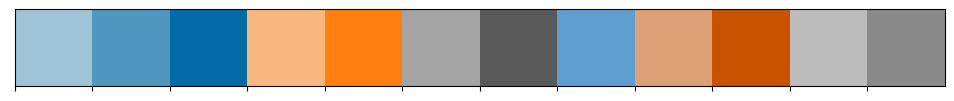

In [17]:
imp_order = full_set_df.sort_values(
    ['ctrl', 'type', 'group', 'imputation'],
    ascending=[True, False, True, True]
)[['group', 'imputation']].drop_duplicates()
colors = imp_order['group'].unique()
n_colors = [len(imp_order[imp_order['group'] == c]) for c in colors]

def generate_color_palette(color_list):
    # Generate a base color palette
    base_palette = sns.color_palette(
        ['#006BA4', '#FF800E', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'], 
        n_colors=len(color_list))
    
    # Generate shades for each base color
    color_palette = []
    for i, color in enumerate(base_palette):
        shades = sns.light_palette(color, n_colors=color_list[i] + 1)
        color_palette.extend(shades[1:])
    
    return color_palette


# Generate the color palette
cset = generate_color_palette(n_colors)
sns.palplot(cset)
print(dict(zip(colors, n_colors)))

In [67]:
dict(zip(imp_order['imputation'], cset))

{'baseline': (0.6257796880873904, 0.7692334467518679, 0.8490464152850072),
 'ctrl': (0.31288984404369524, 0.5944206449445615, 0.746091835093484),
 'ctrl_mean': (0.0, 0.4196078431372549, 0.6431372549019608),
 'fancy_itersvd': (0.976249987924192, 0.7208024833334978, 0.4948461379450622),
 'fancy_multi': (1.0, 0.5019607843137255, 0.054901960784313725),
 'knn_3': (0.6450787385143271, 0.6450943494613806, 0.6450330062267311),
 'knn_5': (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
 'ALRA': (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
 'MAGIC_t1': (0.8679748929727327, 0.6302059588557253, 0.46777925759729744),
 'MAGIC_t3': (0.7843137254901961, 0.3215686274509804, 0.0),
 'dca_nb': (0.7395654837909705, 0.7395810602898067, 0.7395199624957123),
 'dca_zinb': (0.5372549019607843, 0.5372549019607843, 0.5372549019607843)}

In [19]:
for i in range(len(dataset_df)):
    for sparse in [True, False]:
        # size of clustermap plots
        size = 4

        if sparse:
            adata = sc.read_h5ad(dataset_df.iloc[i]['sp_adata_path'])
        else:
            adata = sc.read_h5ad(dataset_df.iloc[i]['adata_path'])
        adata.uns['log1p']['base'] = 10
        write_path = dataset_df.iloc[i]['save_to']
        write_path = '/home/mklein/Dropouts/degs/kendall'
        dataset = dataset_df.iloc[i]['dataset']
        dataset_disp = " ".join(dataset.split('_')[1:])
        print(dataset_disp)
        cond_order_dict = dict(
            Mx_Seahorse=['NStim', 'Stim', '2DG', 'Oligo'],
            Lx_Glioblastoma=['Naive_WT', 'TMD_sM', 'TMD_dM', 'TMD_tM', 'TMD_CD95_WT', 'TMD_CD95_KO'],
            Lx_Pancreatic_Cancer=['HPAF', 'HPAC', 'PSN1', 'MiaPaca2'],
            Lx_HepaRG=['U', 'F', 'FI', 'FIT'],
        )

        cond_order = cond_order_dict[dataset]
        # exclude_imps = ['dca_nb-conddisp', 'dca_zinb-conddisp', 'fancy_softbi', 'bbmagic_1', 'bbmagic_2', 'bbmagic_3', 'bbmagic_5']
        exclude_imps = const.EXCLUDE_IMPUTATION + ['fancy_iterative']
        adata.var.index.name = 'index'
        if sparse:
            dataset = dataset + "_sparse"
        adata.layers


        set_list = []
        for layer in adata.layers.keys():
            adata_imp = adata
            sc.tl.rank_genes_groups(adata_imp, use_raw = False, groupby='condition', method='wilcoxon', key_added = f"wilcoxon_{layer}", layer=layer)
            # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
            for condition in adata_imp.obs['condition'].unique():
                df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=None, log2fc_min=0)#[['names']]
                df['imputation'] = layer
                df['condition'] = condition
                df['direction'] = 'up'
                df['cond'] = condition + " up"
                set_list.append(df.sort_values(by='logfoldchanges', ascending=True))
                # set_list.append(df.sort_values(by='logfoldchanges', ascending=True).head(50))

                df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=None, log2fc_max=0)#[['names']]
                df['imputation'] = layer
                df['condition'] = condition
                df['direction'] = 'down'
                df['cond'] = condition + " down"

                set_list.append(df.sort_values(by='logfoldchanges', ascending=False))
                # set_list.append(df.sort_values(by='logfoldchanges', ascending=False).head(50))

        set_df = pd.concat(set_list, ignore_index=True)
        set_df['group'] = list(set_df['imputation'].apply(lambda x: re.sub('_[^_]+$', '', x)))
        set_df['ctrl'] = [ 'ctrl' if c == 'ctrl' else 'imputation' for c in set_df['group']]

        set_df = set_df[~set_df['imputation'].isin(exclude_imps)]
        set_df['imputation'] = set_df['imputation'].astype('str')

        from scipy.stats import kendalltau, spearmanr
        overlap_list = []
        compared_layers = set_df['imputation'].unique()
        for cond in set_df['condition'].unique():
            incl_metab = full_set_df[(full_set_df['imputation'] == 'baseline') & (full_set_df['condition'] == cond)]['names']
            metab_df = set_df[(set_df['condition'] == cond)]
            print(f"{cond} N metabolites: {len(incl_metab)}")
            for layer1 in list(set(compared_layers).intersection(['ctrl', 'baseline'])):
                for layer2 in compared_layers:
                    r1 = metab_df[metab_df['imputation'] == layer1]
                    r2 = metab_df[metab_df['imputation'] == layer2]
                    r = pd.merge(r1, r2, on=['names'], suffixes=['_1', '_2'], how='inner')

                    kendall = list(kendalltau(r['logfoldchanges_1'], r['logfoldchanges_2']))
                    spearman = spearmanr(r['logfoldchanges_1'], r['logfoldchanges_2'])
                    # print(f"{cond} + {layer1} + {layer2} + {kendall[0]}")
                    if kendall[1] > 0.05:
                        kendall[0] = 0
                    overlap_list.append(dict(
                        cond=cond,
                        direction = 'none',
                        condition = cond,
                        layer1 = layer1,
                        layer2 = layer2,
                        kendall = kendall[0],
                        kendall_P = kendall[1],
                        spearman = spearman[0],
                        spearman_P = spearman[1],
                    ))

        overlap_df = pd.DataFrame(overlap_list)
        overlap_df['cond2'] = overlap_df['cond']
        overlap_df['imputation 1'] = overlap_df['layer1']
        overlap_df['imputation 2'] = overlap_df['layer2']

        out_df = overlap_df.reset_index()
        out_df['dataset'] = dataset
        out_df['sparse'] = sparse
        out_df['dr'] = adata.uns['dropout_rate'] if 'dropout_rate' in adata.uns.keys() else 'baseline'
        out_df.to_csv(os.path.join(write_path, f'{dataset}_kendall_ovlps.csv'))

Glioblastoma
TMD_sM N metabolites: 513
TMD_dM N metabolites: 442
TMD_CD95_WT N metabolites: 509
TMD_tM N metabolites: 384
TMD_CD95_KO N metabolites: 373
Naive_WT N metabolites: 524


In [47]:
for i in range(len(dataset_df)):
    for sparse in [True, False]:

        if sparse:
            adata = sc.read_h5ad(dataset_df.iloc[i]['sp_adata_path'])
        else:
            adata = sc.read_h5ad(dataset_df.iloc[i]['adata_path'])
        adata.uns['log1p']['base'] = 10
        write_path = dataset_df.iloc[i]['save_to']
        write_path = '/home/mklein/Dropouts/degs/jaccard'
        dataset = dataset_df.iloc[i]['dataset']
        dataset_disp = " ".join(dataset.split('_')[1:])
        print(dataset_disp)
        cond_order_dict = dict(
            Mx_Seahorse=['NStim', 'Stim', '2DG', 'Oligo'],
            Lx_Glioblastoma=['Naive_WT', 'TMD_sM', 'TMD_dM', 'TMD_tM', 'TMD_CD95_WT', 'TMD_CD95_KO'],
            Lx_Pancreatic_Cancer=['HPAF', 'HPAC', 'PSN1', 'MiaPaca2'],
            Lx_HepaRG=['U', 'F', 'FI', 'FIT'],
        )

        cond_order = cond_order_dict[dataset]
        # exclude_imps = ['dca_nb-conddisp', 'dca_zinb-conddisp', 'fancy_softbi', 'bbmagic_1', 'bbmagic_2', 'bbmagic_3', 'bbmagic_5']
        exclude_imps = const.EXCLUDE_IMPUTATION + ['fancy_iterative']
        adata.var.index.name = 'index'
        if sparse:
            dataset = dataset + "_sparse"
        adata.layers
        set_list = []
        for layer in adata.layers.keys():
            adata_imp = adata
            sc.tl.rank_genes_groups(adata_imp, use_raw = False, groupby='condition', method='wilcoxon', key_added = f"wilcoxon_{layer}", layer=layer)
            # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
            for condition in adata_imp.obs['condition'].unique():
                df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=0.05, log2fc_min=1)#[['names']]
                df['imputation'] = layer
                df['condition'] = condition
                df['direction'] = 'up'
                df['cond'] = condition + " up"
                set_list.append(df.sort_values(by='logfoldchanges', ascending=True).head(20))

                df = sc.get.rank_genes_groups_df(adata_imp, group=condition, key=f"wilcoxon_{layer}", pval_cutoff=0.05, log2fc_max=-1)#[['names']]
                df['imputation'] = layer
                df['condition'] = condition
                df['direction'] = 'down'
                df['cond'] = condition + " down"
                set_list.append(df.sort_values(by='logfoldchanges', ascending=False).head(20))

        set_df = pd.concat(set_list, ignore_index=True)
        set_df['group'] = list(set_df['imputation'].apply(lambda x: re.sub('_[^_]+$', '', x)))
        set_df['ctrl'] = [ 'ctrl' if c == 'ctrl' else 'imputation' for c in set_df['group']]

        set_df = set_df[~set_df['imputation'].isin(exclude_imps)]
        set_df['imputation'] = set_df['imputation'].astype('str')

        from sklearn.metrics import jaccard_score
        overlap_list = []
        compared_layers = set_df['imputation'].unique()
        for cond in set_df['cond'].unique():
            for layer1 in list(set(compared_layers).intersection(['ctrl', 'baseline'])):
                for layer2 in compared_layers:
                    set1 = set(set_df[(set_df['cond'] == cond) & (set_df['imputation'] == layer1)]['names'])
                    set2 = set(set_df[(set_df['cond'] == cond) & (set_df['imputation'] == layer2)]['names'])
                    array1 = np.array([1 if x in set1 else 0 for x in set(set1.union(set2))])
                    array2 = np.array([1 if x in set2 else 0 for x in set(set1.union(set2))])

                    # print(f"{cond} + {layer1} + {set1}")
                    # print(f"{cond} + {layer2} + {set2}")
                    # print(jaccard_score(array1, array2))
                    overlap_list.append(dict(
                        cond=cond,
                        direction = set_df[(set_df['cond'] == cond)]['direction'].iloc[0],
                        condition = set_df[(set_df['cond'] == cond)]['condition'].iloc[0],
                        layer1 = layer1,
                        layer2 = layer2,
                        jaccard = jaccard_score(array1, array2),
                        recovery = len(set1.intersection(set2)) / len(set1),
                    ))

        overlap_df = pd.DataFrame(overlap_list)
        overlap_df['cond2'] = overlap_df['cond']
        overlap_df['imputation 1'] = overlap_df['layer1']
        overlap_df['imputation 2'] = overlap_df['layer2']

        out_df = overlap_df.reset_index()
        out_df['dataset'] = dataset
        out_df['sparse'] = sparse
        out_df['dr'] = adata.uns['dropout_rate'] if 'dropout_rate' in adata.uns.keys() else 'baseline'
        out_df.to_csv(os.path.join(write_path, 'sign', f'{dataset}_jaccard_ovlps_sign.csv'))

        

Seahorse
Seahorse
Pancreatic Cancer
Pancreatic Cancer
Glioblastoma
Glioblastoma
HepaRG


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:94: RuntimeWarning: overflow encountered in expm1
  self.expm1_func = lambda x: np.expm1(x * np.log(adata.uns['log1p']['base']))


HepaRG


In [48]:
column = 'kendall'
column = 'jaccard'

path = f'/home/mklein/Dropouts/degs/{column}/sign'
# list all directories in the path
files = [d for d in os.listdir(path) if os.path.join(path, d).endswith('csv')]
files.sort()
files

['Lx_Glioblastoma_jaccard_ovlps_sign.csv',
 'Lx_Glioblastoma_sparse_jaccard_ovlps_sign.csv',
 'Lx_HepaRG_jaccard_ovlps_sign.csv',
 'Lx_HepaRG_sparse_jaccard_ovlps_sign.csv',
 'Lx_Pancreatic_Cancer_jaccard_ovlps_sign.csv',
 'Lx_Pancreatic_Cancer_sparse_jaccard_ovlps_sign.csv',
 'Mx_Seahorse_jaccard_ovlps_sign.csv',
 'Mx_Seahorse_sparse_jaccard_ovlps_sign.csv']

In [52]:
if column == "jaccard":
    column = 'recovery'

csv_list = []
for file in files:
    local_df = pd.read_csv(os.path.join(path, file), index_col=0)
    local_df['dataset'] = "_".join(file.split('_')[:-3])
    csv_list.append(local_df)

csv_df = pd.concat(csv_list, ignore_index=True)
csv_df

,index,cond,direction,condition,layer1,layer2,jaccard,recovery,cond2,imputation 1,imputation 2,dataset,sparse,dr
0,0,TMD_sM up,up,TMD_sM,ctrl,ALRA,0.142857,0.25,TMD_sM up,ctrl,ALRA,Lx_Glioblastoma,False,baseline
1,1,TMD_sM up,up,TMD_sM,ctrl,MAGIC_t1,0.481481,0.65,TMD_sM up,ctrl,MAGIC_t1,Lx_Glioblastoma,False,baseline
2,2,TMD_sM up,up,TMD_sM,ctrl,MAGIC_t3,0.176471,0.30,TMD_sM up,ctrl,MAGIC_t3,Lx_Glioblastoma,False,baseline
3,3,TMD_sM up,up,TMD_sM,ctrl,ctrl,1.000000,1.00,TMD_sM up,ctrl,ctrl,Lx_Glioblastoma,False,baseline
4,4,TMD_sM up,up,TMD_sM,ctrl,ctrl_mean,0.025641,0.05,TMD_sM up,ctrl,ctrl_mean,Lx_Glioblastoma,False,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,187,NStim down,down,NStim,ctrl,dca_zinb,0.052632,0.10,NStim down,ctrl,dca_zinb,Mx_Seahorse_sparse,True,0.84
1256,188,NStim down,down,NStim,ctrl,fancy_itersvd,0.176471,0.30,NStim down,ctrl,fancy_itersvd,Mx_Seahorse_sparse,True,0.84
1257,189,NStim down,down,NStim,ctrl,fancy_multi,0.193548,0.30,NStim down,ctrl,fancy_multi,Mx_Seahorse_sparse,True,0.84
1258,190,NStim down,down,NStim,ctrl,knn_3,0.107143,0.15,NStim down,ctrl,knn_3,Mx_Seahorse_sparse,True,0.84


In [53]:
plot_df = csv_df[(csv_df['imputation 1'] == 'ctrl')&(csv_df['imputation 2'] != 'ctr8l')&(csv_df['sparse'] == False)]
plot_df

,index,cond,direction,condition,layer1,layer2,jaccard,recovery,cond2,imputation 1,imputation 2,dataset,sparse,dr
0,0,TMD_sM up,up,TMD_sM,ctrl,ALRA,0.142857,0.25,TMD_sM up,ctrl,ALRA,Lx_Glioblastoma,False,baseline
1,1,TMD_sM up,up,TMD_sM,ctrl,MAGIC_t1,0.481481,0.65,TMD_sM up,ctrl,MAGIC_t1,Lx_Glioblastoma,False,baseline
2,2,TMD_sM up,up,TMD_sM,ctrl,MAGIC_t3,0.176471,0.30,TMD_sM up,ctrl,MAGIC_t3,Lx_Glioblastoma,False,baseline
3,3,TMD_sM up,up,TMD_sM,ctrl,ctrl,1.000000,1.00,TMD_sM up,ctrl,ctrl,Lx_Glioblastoma,False,baseline
4,4,TMD_sM up,up,TMD_sM,ctrl,ctrl_mean,0.025641,0.05,TMD_sM up,ctrl,ctrl_mean,Lx_Glioblastoma,False,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,83,NStim down,down,NStim,ctrl,dca_zinb,0.081081,0.15,NStim down,ctrl,dca_zinb,Mx_Seahorse,False,baseline
1064,84,NStim down,down,NStim,ctrl,fancy_itersvd,0.081081,0.15,NStim down,ctrl,fancy_itersvd,Mx_Seahorse,False,baseline
1065,85,NStim down,down,NStim,ctrl,fancy_multi,0.081081,0.15,NStim down,ctrl,fancy_multi,Mx_Seahorse,False,baseline
1066,86,NStim down,down,NStim,ctrl,knn_3,0.081081,0.15,NStim down,ctrl,knn_3,Mx_Seahorse,False,baseline


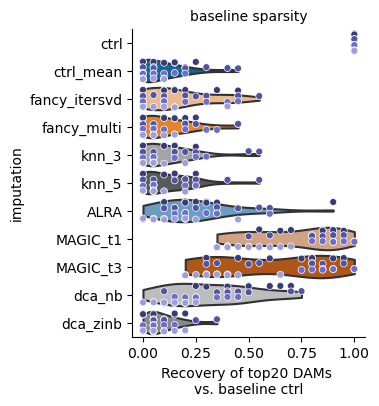

In [61]:
fig, ax = plt.subplots(1,1, figsize=(3, 4))
sns.violinplot(cut=0, scale='width',
    data=plot_df.reset_index(),
    y='imputation 2', x=column, order=imp_order['imputation'][1:], palette=cset[1:],
    #col='dataset'
    height=4, inner=None, ax=ax)
sns.stripplot(
    data=plot_df.reset_index(), 
    y='imputation 2', x=column, 
    dodge=True,
    hue='dataset', palette='tab20b', hue_order=['Mx_Seahorse', 'Lx_HepaRG', 'Lx_Pancreatic_Cancer', 'Lx_Glioblastoma'],
    order=imp_order['imputation'][1:], size=5, ax=ax, linewidth=0.5, edgecolor='white'
)
ax.set_title("baseline sparsity", size=10)

if column == 'jaccard':
    ax.set_xlabel(f"Jaccard similarity of top50 \nDAMs vs. baseline ctrl")
elif column == 'recovery':
    ax.set_xlabel(f"Recovery of top20 DAMs \nvs. baseline ctrl")
else:
    ax.set_xlabel(r"Kendall $\tau$ of logFC vs. "+f"\nbaseline ctrl")

ax.set_ylabel('imputation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-0.05, 1.05)

ax.legend_.remove()
fig.savefig(os.path.join(write_path, f"fc_plot_baseline_{column}.pdf"), bbox_inches='tight')


In [55]:
plot_sparse_df = csv_df.loc[(csv_df['imputation 1'] == 'baseline') & (csv_df['imputation 2'] != 'baseline') & (csv_df['sparse'] == True)].copy()
plot_sparse_df['dataset'] = [" ".join(d.split('_')[1:-1]) for d in plot_sparse_df['dataset']]
plot_sparse_df

,index,cond,direction,condition,layer1,layer2,jaccard,recovery,cond2,imputation 1,imputation 2,dataset,sparse,dr
132,0,TMD_sM up,up,TMD_sM,baseline,ALRA,0.052632,0.10,TMD_sM up,baseline,ALRA,Glioblastoma,True,0.86
133,1,TMD_sM up,up,TMD_sM,baseline,MAGIC_t1,0.333333,0.50,TMD_sM up,baseline,MAGIC_t1,Glioblastoma,True,0.86
134,2,TMD_sM up,up,TMD_sM,baseline,MAGIC_t3,0.081081,0.15,TMD_sM up,baseline,MAGIC_t3,Glioblastoma,True,0.86
136,4,TMD_sM up,up,TMD_sM,baseline,ctrl,0.250000,0.40,TMD_sM up,baseline,ctrl,Glioblastoma,True,0.86
137,5,TMD_sM up,up,TMD_sM,baseline,ctrl_mean,0.000000,0.00,TMD_sM up,baseline,ctrl_mean,Glioblastoma,True,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,175,NStim down,down,NStim,baseline,dca_zinb,0.052632,0.10,NStim down,baseline,dca_zinb,Seahorse,True,0.84
1244,176,NStim down,down,NStim,baseline,fancy_itersvd,0.111111,0.20,NStim down,baseline,fancy_itersvd,Seahorse,True,0.84
1245,177,NStim down,down,NStim,baseline,fancy_multi,0.088235,0.15,NStim down,baseline,fancy_multi,Seahorse,True,0.84
1246,178,NStim down,down,NStim,baseline,knn_3,0.033333,0.05,NStim down,baseline,knn_3,Seahorse,True,0.84


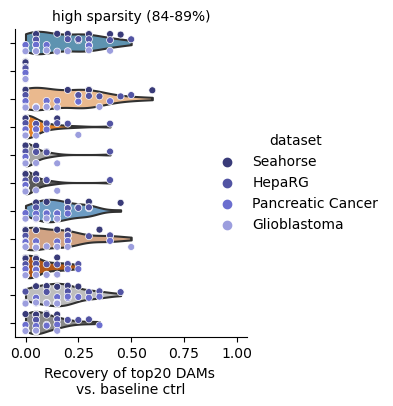

In [62]:
fig, ax = plt.subplots(1,1, figsize=(3, 4))
sns.violinplot(cut=0, scale='width',
    data=plot_sparse_df,
    y='imputation 2', x=column, order=imp_order['imputation'][1:], palette=cset[1:],
    #col='dataset'
    height=4, inner=None, ax=ax)
sns.stripplot(
    data=plot_sparse_df, 
    y='imputation 2', x=column, 
    dodge=True,
    hue='dataset', palette='tab20b', hue_order=['Seahorse', 'HepaRG', 'Pancreatic Cancer', 'Glioblastoma'],
    order=imp_order['imputation'][1:], 
    size=5, ax=ax, linewidth=0.5, edgecolor='white'
)
ax.set_title("high sparsity (84-89%)", size=10)

if column == 'jaccard':
    ax.set_xlabel(f"Jaccard similarity of top50 \nDAMs vs. baseline ctrl")
elif column == 'recovery':
    ax.set_xlabel(f"Recovery of top20 DAMs \nvs. baseline ctrl")
else:
    ax.set_xlabel(r"Kendall $\tau$ of logFC vs. "+f"\nbaseline ctrl")

ax.set_ylabel(None)
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-0.05, 1.05)

ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.5), title='dataset', frameon=False)
fig.savefig(os.path.join(write_path, f"fc_plot_sparse_{column}.pdf"), bbox_inches='tight')


In [64]:
plot_df.groupby(['imputation 2']).mean()

/tmp/ipykernel_279/2022639910.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_df.groupby(['imputation 2']).mean()


,index,jaccard,recovery,sparse
imputation 2,,,,
ALRA,45.833333,0.155920,0.254167,0.0
MAGIC_t1,46.833333,0.597051,0.713889,0.0
MAGIC_t3,47.833333,0.494683,0.604167,0.0
ctrl,48.833333,1.000000,1.000000,0.0
ctrl_mean,49.833333,0.063615,0.094444,0.0
dca_nb,50.833333,0.212289,0.322222,0.0
dca_zinb,51.833333,0.055723,0.090278,0.0
fancy_itersvd,52.833333,0.108313,0.165278,0.0
fancy_multi,53.833333,0.072594,0.118056,0.0


In [ ]:
plot_sparse_df.groupby(['imputation 2']).mean()

/tmp/ipykernel_279/930573295.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_sparse_df.groupby(['imputation 2']).mean()


,index,jaccard,recovery,sparse
imputation 2,,,,
ALRA,100.0,0.091155,0.158333,1.0
MAGIC_t1,101.0,0.084549,0.137500,1.0
MAGIC_t3,102.0,0.038203,0.068056,1.0
ctrl,104.0,0.115998,0.183333,1.0
ctrl_mean,105.0,0.000000,0.000000,1.0
dca_nb,106.0,0.094143,0.161111,1.0
dca_zinb,107.0,0.053262,0.090278,1.0
fancy_itersvd,108.0,0.115607,0.181944,1.0
fancy_multi,109.0,0.032803,0.048611,1.0
